In [3]:
import os
import pandas as pd
import numpy as np
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sn

# Exploration and trasformation of data

1. Import data to pandas Dataframe

In [4]:
df = pd.read_csv(os.path.join(os.getcwd(),'final_redshift_table.csv'))

2. Feature transformation and engineering

Change datetime string to datetime object

In [5]:
for col in ['end_variant', 'start_variant', 'signup_date', 'purchased_at_trial', 'purchased_at_sub']:
    df[col] = pd.to_datetime(df[col])

Number of days for each variant

In [6]:
df['days_diff'] = (df['end_variant']-df['start_variant']).dt.days

Number of days needed from the signup to subscription datetime

In [7]:
df['days_signup_sub'] = (df['purchased_at_sub']-df['signup_date']).dt.days

3. Description of Dataframe columns

In [8]:
df.columns

Index(['user_id', 'end_variant', 'start_variant', 'variant', 'signup_date',
       'trial', 'plan_id_trial', 'subscription', 'plan_id_sub',
       'purchased_at_trial', 'purchased_at_sub', 'amount', 'days_diff',
       'days_signup_sub'],
      dtype='object')

In [9]:
df.dtypes

user_id                       object
end_variant           datetime64[ns]
start_variant         datetime64[ns]
variant                       object
signup_date           datetime64[ns]
trial                        float64
plan_id_trial                 object
subscription                 float64
plan_id_sub                   object
purchased_at_trial    datetime64[ns]
purchased_at_sub      datetime64[ns]
amount                       float64
days_diff                      int64
days_signup_sub              float64
dtype: object

- `user_id` : unique id for users
- `end_variant`: minimum assigned datetime of the variant
- `start_variant`: maximum assigned datetime of the variant
- `variant`: name of A/B test variant : CONTROL/TREATMENT
- `signup_date`: datetime when the user signed up 
- `trial`: whether the user started a 7-days free trial - 1 or NaN
- `plan_id_trial`: subscription plan for which the user started a free trial
- `subscription`: whether the user subscribed - 1 or NaN
- `plan_id_sub`: subscription plan
- `purchased_at_trial`: datetime when the user started the free trial
- `purchased_at_sub`: datetime when the user subscribed for a specific plan
- `amount`: paid amount for the subscription to a specific plan

4. Equal number of days for the CONTROL and TREATMENT groups: 18 days

In [10]:
df.loc[(df.variant=="CONTROL")]['days_diff'].unique()

array([18])

In [11]:
df.loc[(df.variant=="TREATMENT")]['days_diff'].unique()

array([18])

5. Checking for errors in assigning users to the each variant

In [12]:
df.loc[(df.variant=="CONTROL") & (df.trial==1)]

,user_id,end_variant,start_variant,variant,signup_date,trial,plan_id_trial,subscription,plan_id_sub,purchased_at_trial,purchased_at_sub,amount,days_diff,days_signup_sub
3391,8e16a33ed971091fdc32af60685c81db,2019-06-24 14:10:50.938540,2019-06-06 09:38:45.209868,CONTROL,2019-06-20 13:54:53.715,1.0,6-months,1.0,6-months,2019-06-20 13:59:45,2019-06-27 13:59:45,12.0,18,7.0
12889,b696fc0c2b72d780ede50c4e481f2f4c,2019-06-24 14:10:50.938540,2019-06-06 09:38:45.209868,CONTROL,2019-06-22 06:58:47.257,1.0,6-months,NaN,NaN,2019-11-03 14:53:53,NaT,NaN,18,NaN
12998,f0d5ce4706b32ef7ba8f2cafe7895b19,2019-06-24 14:10:50.938540,2019-06-06 09:38:45.209868,CONTROL,2019-06-22 14:39:26.118,1.0,6-months,1.0,12-months,2019-06-24 08:03:00,2019-07-01 10:51:22,26.0,18,8.0


This is clearly a sampling error, because in the control variant there is not free-trial option. For this reason these three instances will be removed from the dataframe.

In [13]:
df = df.drop(df[(df.variant=="CONTROL") & (df.trial==1)].index)

For the treatment group we expect to have 3 possible cases: 
1. users who had subscriptions without 7-days free trial
2. users who started 7-days free trials without a subscription afterwards
3. users who started 7-days free trials with a subscription afterwards

In [14]:
df.loc[(df.variant=="TREATMENT") & (df.trial.isna()==True) & (df.subscription==1)].head()

,user_id,end_variant,start_variant,variant,signup_date,trial,plan_id_trial,subscription,plan_id_sub,purchased_at_trial,purchased_at_sub,amount,days_diff,days_signup_sub
14415,21f78b872332d9893c68ea3cdf6d3d0e,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-20 20:43:57.798,NaN,NaN,1.0,1-month,NaT,2019-08-15 09:56:10,4.0,18,55.0
14442,28bd4fa68e697440e501a95edf5692fa,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-20 08:03:03.913,NaN,NaN,1.0,1-month,NaT,2019-06-20 14:35:45,4.0,18,0.0
14623,5197afdcdb7173ddef76ed5c38bb1a72,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-23 00:09:52.244,NaN,NaN,1.0,1-month,NaT,2019-06-23 20:36:46,4.0,18,0.0
14642,1ddb561b471fe41c6ac6883e13bdfcb0,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-22 08:56:56.135,NaN,NaN,1.0,12-months,NaT,2019-06-22 09:37:50,26.0,18,0.0
14658,5972cc3f651794517aec7ffb8e110224,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-21 09:51:26.207,NaN,NaN,1.0,12-months,NaT,2019-06-29 07:36:56,23.0,18,7.0


In [15]:
df.loc[(df.variant=="TREATMENT") & (df.trial==1) & (df.subscription.isna()==True)].head()

,user_id,end_variant,start_variant,variant,signup_date,trial,plan_id_trial,subscription,plan_id_sub,purchased_at_trial,purchased_at_sub,amount,days_diff,days_signup_sub
14332,3eea7e4cf690ef90aee61c112ab65999,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-09 07:37:05.899,1.0,6-months,NaN,NaN,2019-06-09 07:37:23,NaT,NaN,18,NaN
14341,2c4c23a79cebc6a5e1ab2c570b65733a,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-09 01:37:18.040,1.0,6-months,NaN,NaN,2019-06-09 01:37:53,NaT,NaN,18,NaN
14387,643a3a383a78944efe2a0df3ecf1921f,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-14 17:10:28.198,1.0,6-months,NaN,NaN,2019-06-14 17:10:41,NaT,NaN,18,NaN
14539,2e69f2e8a4e12cf2e399ff656a38d9a4,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-23 08:07:20.753,1.0,6-months,NaN,NaN,2019-06-23 08:07:43,NaT,NaN,18,NaN
14540,65c18499e94331d9e1964ca25b94a8f7,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-24 11:11:02.151,1.0,6-months,NaN,NaN,2019-06-24 11:11:19,NaT,NaN,18,NaN


In [16]:
df.loc[(df.variant=="TREATMENT") & (df.trial==1) & (df.subscription==1)].head()

,user_id,end_variant,start_variant,variant,signup_date,trial,plan_id_trial,subscription,plan_id_sub,purchased_at_trial,purchased_at_sub,amount,days_diff,days_signup_sub
14352,476358b7b21556c594d5ba7c76237d2a,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-12 02:18:10.089,1.0,6-months,1.0,6-months,2019-06-12 02:19:53,2019-06-19 02:19:53,13.0,18,7.0
14356,26a0ce7d6bb1c1398b49241028bf5d55,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-13 00:44:22.413,1.0,6-months,1.0,1-month,2019-06-13 00:45:00,2019-07-06 21:21:16,4.0,18,23.0
14416,56a170156385869be953ec09aceb2301,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-15 17:12:12.215,1.0,6-months,1.0,6-months,2019-06-15 17:12:27,2019-06-22 17:12:27,12.0,18,7.0
14423,697b0954ba7dca501ab8e593384dd506,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-19 19:45:01.705,1.0,6-months,1.0,6-months,2019-06-19 19:45:15,2019-06-26 19:45:15,12.0,18,7.0
14448,68cb3adc04eb5ff2beeb6589f4656e40,2019-06-24 14:11:08.027184,2019-06-06 09:31:54.843755,TREATMENT,2019-06-23 08:34:26.873,1.0,6-months,1.0,6-months,2019-06-23 08:34:47,2019-06-30 08:34:47,12.0,18,7.0


# A/B Testing: chosen KPIs

- **Conversion Rate (CR) (or Subscription Rate)** : The percentage of signed-up visitors that subscribed for a plan. This action converts them from visitors to customers. The conversion rate is defined as: __number of customers who subscribed/number of unique visitors__

- **Average Order Value (AOV)**: Only tracking the CR is not a good idea. Indeed we have to consider also the revenue : sometimes it may so happen that revenues can drop because of a dip in subscriptions among high paying customers (meaning less 1-year or lifetime and more 1-month subscription plans). In order to tackle this case the Average Order Value must be tracked, defined as : **Total revenue/number of customers who subscribed**

- **Retention Rate**: If these users do not become to paying members after the trial period, it could actually be losing revenue for the company. So it is important also to check the retention rate defined as: **number of successful renewals after the trial / number of unique free-trial users**

# A/B Testing: statistics

- __Confidence level__ : The interval estimate is slightly more complex and depends partly on how certain we need to be in our estimate. For A/B testing usually we have a confidence interval of 95%. A 95 percent confidence level indicates we are 95 percent confident the true population value lies under this interval.

- __alpha (α)__ : alpha refers to the likelihood that the true population value lies outside the confidence interval. Thus, if the confidence level is 95%, then _alpha_ would equal 1 - 0.95 and thus 0.05. Indeed alpha is the probability of making a Type I error, which is asserting something that is absent (false positive).

- __beta (β)__ : I decided to have a statistical power of 0.80 and from that I calculated the minumum sample size:

    - _conversion rate (CR)_ : I have seen that the conversion rate of the treatment group (4.19%) was 33.91% higher than control group (3.13%) with probability that the test correctly rejects the null hypothesis of 80%. I used an online calculator to get the needed sample size of the treatment group, which is of 1293 for:
       1. baseline CR of 3.13 %
       2. minimum detectable effect of 2%
       3. power of 0.80
       4. alpha of 0.05

    - _average order value (AOV)_: for a not-binary metric there is not an online calculator. So since I used a non-parametric test (Mann-Whitney U test) to test differences in the variants for AOV, I decided to calculate the needed sample size for its parametric equivalent - T-test in Python (by using the method solve_power() from the TTestIndPower class of the statsmodels library) and then multiply it by 1.15, because for non-parametric test the sample size is most 15% bigger than the sample size required for the parametric alternative. So the minimal sample size is of 30 for :
        1. large effect size for Cohen’s d of 0.80
        2. power of 0.80
        3. alpha of 0.05

Python code for the calculation of AOV minimal sample size:

In [46]:
analysis = TTestIndPower()
effect_size = 0.8
alpha = 0.05
power = 0.8
multiply_mwutest = 1.15
sample_size_ttest = analysis.solve_power(effect_size,
                                         power=power,
                                         nobs1=None,
                                         ratio=0.5,
                                         alpha=alpha)
sample_size_mwutest = sample_size_ttest * multiply_mwutest
print('Minimal sample size for Mann-Whitney U test: %.3f' % sample_size_mwutest)

Minimal sample size for Mann-Whitney U test: 43.833


## Conversion Rate: Z-test 

In [18]:
control_subscriptions = df.loc[(df.subscription==1) 
                             & (df.variant=="CONTROL")]["user_id"].count()

In [19]:
control_unique_visitors = df.loc[df.variant=="CONTROL"]["user_id"].count()

In [20]:
treatment_subscriptions = df.loc[(df.subscription==1) 
                             & (df.variant=="TREATMENT")]["user_id"].count()

In [21]:
treatment_unique_visitors = df.loc[df.variant=="TREATMENT"]["user_id"].count()

In [22]:
print('Conversion Rate of Control Group: €', control_subscriptions/control_unique_visitors)
print('Conversion Rate of Treatment Group: €', treatment_subscriptions/treatment_unique_visitors)

Conversion Rate of Control Group: € 0.03129584352078239
Conversion Rate of Treatment Group: € 0.04190959599423829


In [23]:
cr_df = pd.DataFrame({
    "Subscribed": [control_subscriptions, treatment_subscriptions],
    "Total": [control_unique_visitors, treatment_unique_visitors]
    }, index=['CONTROL', 'TREATMENT'])

For our CR metric, z-test is conducted: firstly we check whether the two CONTROL and TREATMENT groups differ. 

In [24]:
ztest1, pval_ztest1 = proportions_ztest(
    count=cr_df.Subscribed, nobs=cr_df.Total, alternative='two-sided')

In [25]:
if pval_ztest1<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

reject null hypothesis


Yes they differ. Now it is time to conduct one-sided Z test. We set the alternative as : smaller meanining that the alternative hypothesis H1 is CONTROL CR < TREATMENT CR.

In [26]:
ztest2, pval_ztest2 = proportions_ztest(
    count=cr_df.Subscribed, nobs=cr_df.Total, alternative='smaller')

In [27]:
if pval_ztest1<0.025:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

reject null hypothesis


We can accept the alternative hypothesis being that the conversion rate of the alternative treatment is smaller than the control group. So we can say that the **TREATMENT variant with a 7-days free trial is the winning variant for the conversion rate**.

## Average Order Value : Mann-Whitney U test

Now an analysis is conducted to see whether the two groups , CONTROL and TREATMENT, differ for the second chosen matric, the average order value. We first calculate it for each group.

In [28]:
control_aov = df.loc[(df.subscription==1) 
                             & (df.variant=="CONTROL")]["amount"].sum()/control_subscriptions

In [29]:
treatment_aov = df.loc[(df.subscription==1) 
                             & (df.variant=="TREATMENT")]["amount"].sum()/treatment_subscriptions

In [30]:
print('Average Order Value of Control Group: €', control_aov)
print('Average Order Value of Treatment Group: €', treatment_aov)

Average Order Value of Control Group: € 12.448660714285714
Average Order Value of Treatment Group: € 11.74631751227496


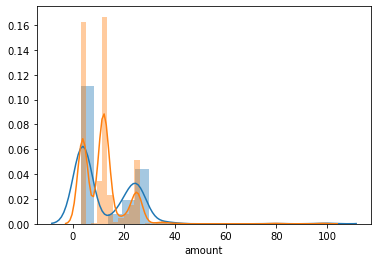

In [31]:
sn.distplot(df.loc[(df.subscription==1) 
                             & (df.variant=="CONTROL")]["amount"])
sn.distplot(df.loc[(df.subscription==1) 
                             & (df.variant=="TREATMENT")]["amount"])

Since we want to compare differences between two independent groups (with different sample sizes) for the continuous variable amount, but the groups are not normally distributed as we can see from the histogram above, the Mann-Whitney U test is used.

In [32]:
stat1, pval_mw1 = mannwhitneyu(df.loc[(df.subscription==1) 
                             & (df.variant=="CONTROL")]["amount"], 
                               df.loc[(df.subscription==1) 
                             & (df.variant=="TREATMENT")]["amount"], alternative='two-sided')

In [33]:
if pval_mw1<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

accept null hypothesis


The null hypothesis is accepted that the AOV for the CONTROL and EXPERIMENT groups don't differ significantly.

## Retention Rate and exploratory analysis 

In [34]:
successful_renewals = df.loc[(df.trial==1) & (df.subscription==1) 
                             & (df.variant=="TREATMENT")]["user_id"].count()

In [35]:
number_free_trial_users = df.loc[(df.trial==1)
                             & (df.variant=="TREATMENT")]["user_id"].count()

In [36]:
print('Retention Rate for the 7-days free trial: ', successful_renewals/number_free_trial_users)

Retention Rate for the 7-days free trial:  0.3684210526315789


We can see that 36% of the users who started the 7-days free trial eventually subscribed for a specific plan.

In [37]:
df.loc[(df.trial==1) 
       & (df.subscription==1) 
       & (df.variant=="TREATMENT")]["plan_id_sub"].value_counts()/successful_renewals

6-months     0.914286
1-month      0.057143
12-months    0.025397
3-months     0.003175
Name: plan_id_sub, dtype: float64

We can also add that the most chosen plan after the trial is the 6-months plan for the trial users who subscribed.

In [38]:
successful_renewals_df = df.loc[(df.trial==1) 
       & (df.subscription==1) & (df.variant=="TREATMENT")]

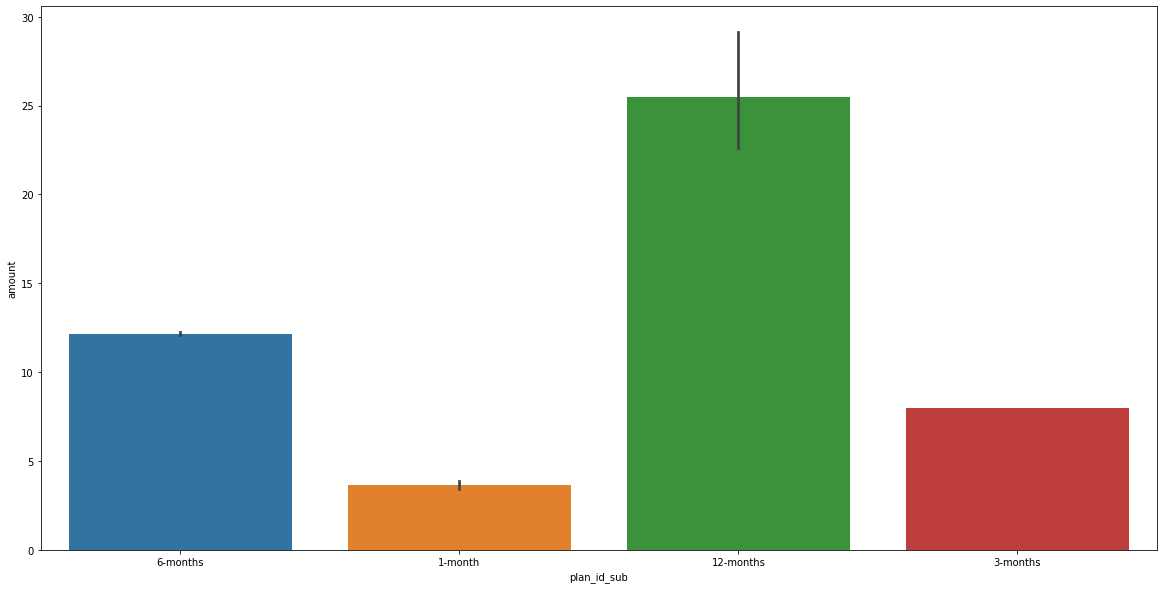

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(data=successful_renewals_df[['amount', 'plan_id_sub']],
            x='plan_id_sub', y='amount', ax=ax)

The revenue mean in euros for subscription plans after a trial period are:
- 6-months plan: 12.12 €
- 1-month plan: 3.66 €
- 12-months plan: 25.50 €
- 8-months plan: 8.0 €

In [40]:
df['types_subscriptions'] = np.nan
df.loc[(df.subscription==1) & (df.variant=="CONTROL"), 'types_subscriptions'] = 'control_subscr'
df.loc[(df.trial.isna()==True) 
       & (df.subscription==1) 
       & (df.variant=="TREATMENT"), 'types_subscriptions'] = 'treatment_subscr'
df.loc[(df.trial==1) 
       & (df.subscription==1) 
       & (df.variant=="TREATMENT"), 'types_subscriptions'] = 'treatment_trial_subscr'

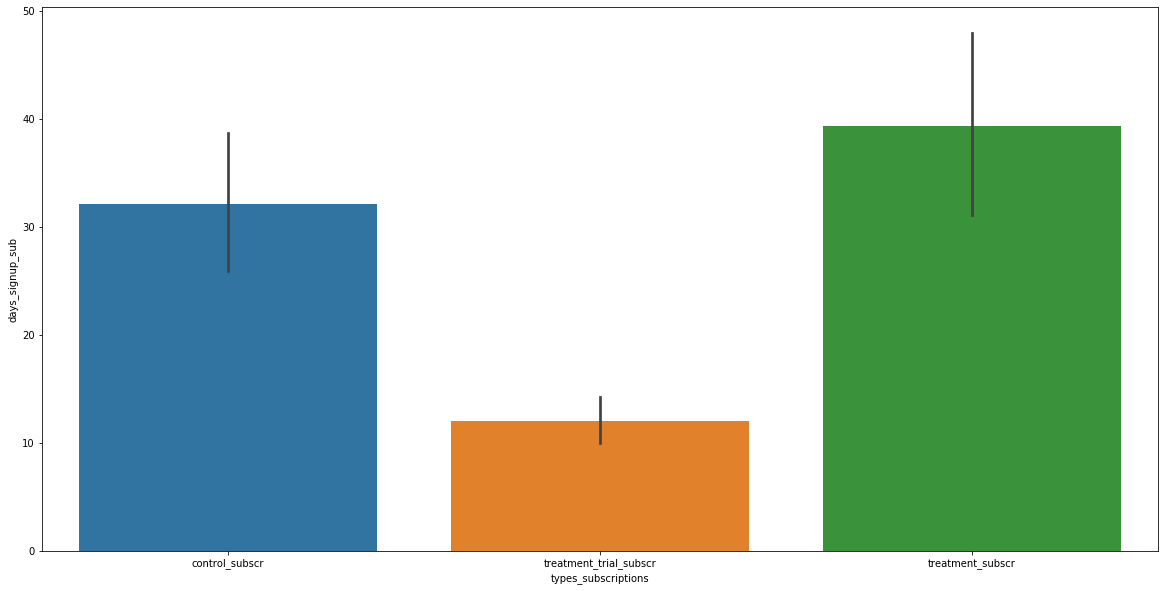

In [41]:
df_days_sub = df.loc[df.days_signup_sub!=0]
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(data=df_days_sub[['days_signup_sub', 'types_subscriptions']],
            x='types_subscriptions', y='days_signup_sub', ax=ax)

On the graph above, the days mean from the signup date to the subscriptions with the types of subscriptions is displayed. On the x-axis, the subscription without 7-days free trial type from the control group (blue bar), the subscription without 7-days free trial type from the tratment group (green bar) and the subscription with 7-days free trial type from the treatment group (orange bar) are depicted. Interestingly, the days' mean for the same subscription without free trial change between CONTROL and TREATMENT groups, showing that in the TREATMENT group users need more time.

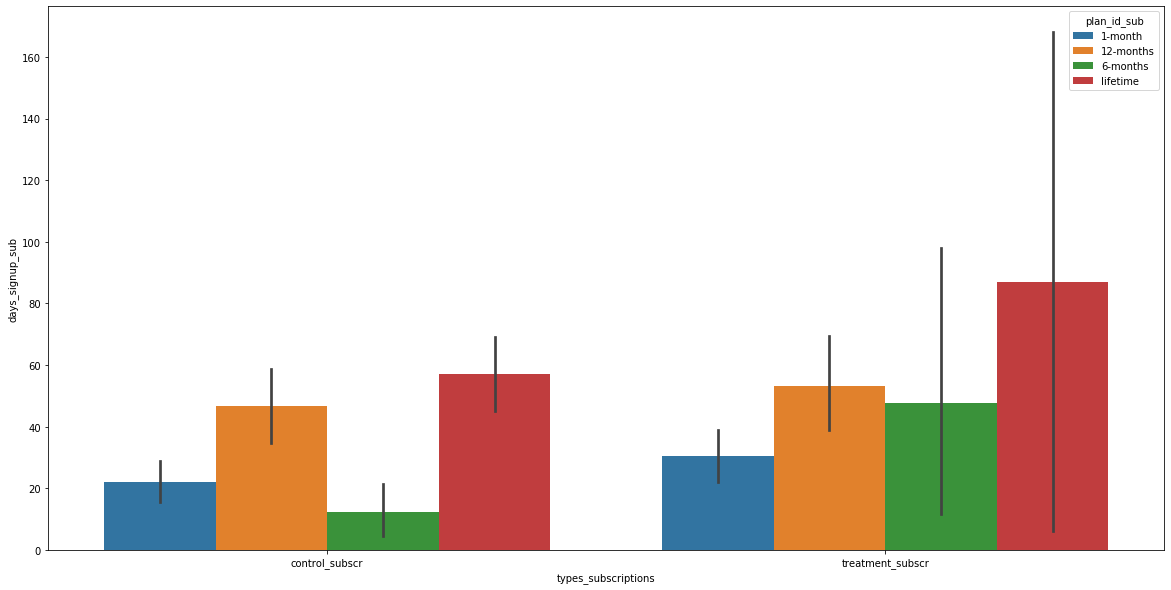

In [42]:
df_days_sub = df_days_sub.loc[df_days_sub.types_subscriptions!='treatment_trial_subscr']
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(data=df_days_sub[['days_signup_sub', 'types_subscriptions', 'plan_id_sub']],
            x='types_subscriptions', y='days_signup_sub', hue='plan_id_sub', ax=ax)

In order to explore in depth the data, the graph above displays the plan types for the control and treatment subscription without the free trial. 
- both group suscriptions show the same types of chosen plans
- the days' mean is higher in general for the treatment group compared to the control group, particularly for the 6-months and lifetime plans, although also their variance is also higher.


Further analysis would be beneficial.

# Intepretation of results

The subscription plans with the option of a 7-days free trial (treatment group) is tested with the control version of different subscription plans (control group). As metrics the conversion rate and average order value are considered. 

For the conversion rate of the treatment group resulted to be significantly higher than the control group, recognizing the treatment variant as the winning variant. Furthermore, it can occur that although the conversation rate has been increased with the free-trial option, there could be a revenue decrease because of an increase of low-price subscription plans. For this reason the average of order price is also taken into consideration, which results not to significantly change in the winning variant from the control group.

Additional exploratory analysis has been conducted, finding that 36% of users starting the 7-days free trial ended up subscribing for the 91% of the time for the 6-months plan, with a revenue mean of 12.12 €. Furthermore, it seems that the users suscribing without a free trial, are faster when they are not provided with a free-trial option. This must be further analysed.